In [363]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [364]:
words = open("lines.txt", 'r').read().splitlines()
words = [wr.replace("/", "").replace("$", "") for wr in words]
words[:10]

["delicate savage  you'll never hold the cinder  but still you will burn ",
 'our destination  the skyline of this city  shining horizon ',
 'a splash and a cry   words pulled from the riverside   dried in the hot sun ',
 'hurt but poised for war  sturdy in crestfallen slumps  warrior spirit ',
 'steamy mist rising  rocks receiving downward crash  as the jungle weeps ',
 'a sultry wine night   spent with a beautiful girl   brash kiss ends smooth jazz ',
 'you were broken glass  but i touched you even though  i knew it would hurt ',
 'say not that i have  fled from the world but that the  world has fled from me ',
 'eyes dance with firelight  the moon and i are lovers  the spiteful sun dies ',
 'i woke up today  i wanted to write a song  i wrote a haiku ']

In [365]:
len(words)

11269

In [366]:
unwanted_chars = ['ß', 'à', 'ä', 'ç', 'è', 'é', 'ï', 'ñ', 'ó', 'ö', 'ü', 'ā']

def contains_unwanted_chars(word):
    return any(char in unwanted_chars for char in word)

filtered_haikus = [haiku for haiku in words if not any(contains_unwanted_chars(word) for word in haiku)]

In [367]:
words = filtered_haikus
len(words)

11235

In [368]:
chars = sorted(list(set(''.join(words)))) #+ ["<S>", "<M>", "<E>"]
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

In [369]:
stoi

{' ': 0,
 "'": 1,
 ',': 2,
 '.': 3,
 'a': 4,
 'b': 5,
 'c': 6,
 'd': 7,
 'e': 8,
 'f': 9,
 'g': 10,
 'h': 11,
 'i': 12,
 'j': 13,
 'k': 14,
 'l': 15,
 'm': 16,
 'n': 17,
 'o': 18,
 'p': 19,
 'q': 20,
 'r': 21,
 's': 22,
 't': 23,
 'u': 24,
 'v': 25,
 'w': 26,
 'x': 27,
 'y': 28,
 'z': 29}

In [391]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [3] * block_size
        #print(w)
        # w = w.split("  ")
        # chs = ["<S>"] + list(w[0]) + ["<M>"] + list(w[1])+ ["<M>"] + list(w[2]) + ["<E>"]
        for ch in w + ".": #chs:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(f"'{''.join(itos[i] for i in context)}'", '---->', itos[ix])

            context = context[1:] + [ix]
    
    X, Y = torch.tensor(X), torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random
random.seed(43)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([637487, 3]) torch.Size([637487])
torch.Size([79514, 3]) torch.Size([79514])
torch.Size([79753, 3]) torch.Size([79753])


## Improved?

In [413]:
g = torch.Generator().manual_seed(213139812739)
C = torch.randn(len(chars), 10, generator=g)

W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)

W2 = torch.randn((200, len(chars)), generator=g)
b2 = torch.randn(len(chars), generator=g)
params = [C, W1, b1, W2, b2]

In [414]:
sum(p.numel() for p in params)

12530

In [415]:
for param in params:
    param.requires_grad = True

In [416]:
lre = torch.linspace(-3, 0, 50000)
lrs = 10 ** lre

In [417]:
lri = []
lrei = []

In [418]:
lr = 0.01
lossiter = []
stepiter = []

for i in range(50000):
    # lr = lrs[i]
    # minibatch
    ix = torch.randint(0, Xtrain.shape[0], (128, ))

    # forward
    emb = C[Xtrain[ix]] # 32, 3, 2
    emb = emb.view(emb.shape[0], -1) # 32, 6
    out = emb @ W1 + b1
    out = F.tanh(out)
    logits = out @ W2 + b2

    # loss calc
    loss = F.cross_entropy(logits, Ytrain[ix])
    if i % 1000 == 0:
        print(f"Iter: {i}, lr: {lr}, loss: {loss.item()}")

    lossiter.append(loss.item())
    stepiter.append(i)

    # backward
    for p in params:
        p.grad = None
    loss.backward()

    # update
    for p in params:
        p.data += -lr * p.grad
    
    # tracking
    # lri.append(lr)
    # lrei.append(lre[i])
    # lossi.append(loss.item())

print(f"Final loss: ",loss.item())

Iter: 0, lr: 0.01, loss: 26.259309768676758
Iter: 1000, lr: 0.01, loss: 8.999091148376465
Iter: 2000, lr: 0.01, loss: 6.3076019287109375
Iter: 3000, lr: 0.01, loss: 5.805086612701416
Iter: 4000, lr: 0.01, loss: 4.205593585968018
Iter: 5000, lr: 0.01, loss: 3.8708038330078125
Iter: 6000, lr: 0.01, loss: 3.796966791152954
Iter: 7000, lr: 0.01, loss: 4.196892738342285
Iter: 8000, lr: 0.01, loss: 3.1345255374908447
Iter: 9000, lr: 0.01, loss: 3.303349256515503
Iter: 10000, lr: 0.01, loss: 3.7486391067504883
Iter: 11000, lr: 0.01, loss: 3.4578428268432617
Iter: 12000, lr: 0.01, loss: 3.0690462589263916
Iter: 13000, lr: 0.01, loss: 2.819486141204834
Iter: 14000, lr: 0.01, loss: 3.3944225311279297
Iter: 15000, lr: 0.01, loss: 2.8961734771728516
Iter: 16000, lr: 0.01, loss: 3.02994441986084
Iter: 17000, lr: 0.01, loss: 2.6246495246887207
Iter: 18000, lr: 0.01, loss: 2.7018895149230957
Iter: 19000, lr: 0.01, loss: 3.0024423599243164
Iter: 20000, lr: 0.01, loss: 2.6236960887908936
Iter: 21000, l

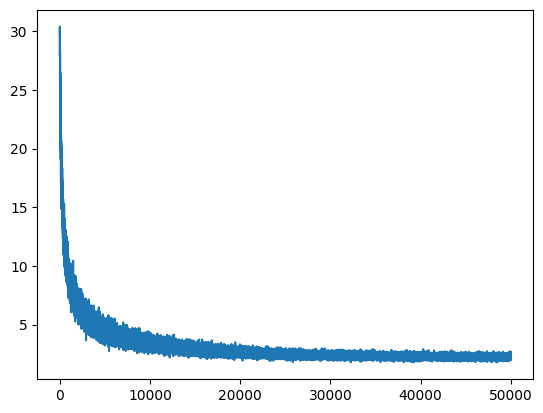

In [405]:
#0.01 lr
plt.plot(stepiter, lossiter)

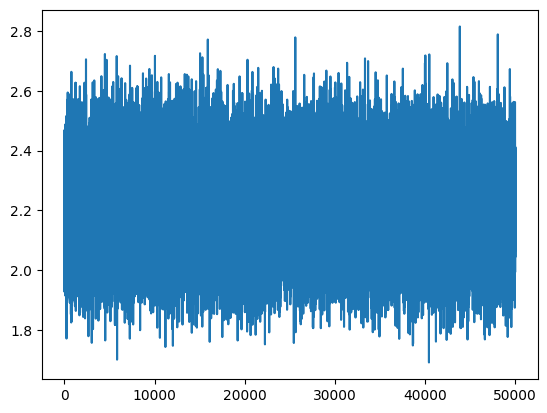

In [407]:
#0.001 lr
plt.plot(stepiter, lossiter)

In [408]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtrain, Ytrain),
        'dev': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }[split]
    emb = C[x]
    emb = emb.view(emb.shape[0], -1)
    out = emb @ W1 + b1
    logits = F.tanh(out) @ W2 + b2
    loss = F.cross_entropy(logits, y)

    return loss.item()

split_loss('train'), split_loss('dev'), split_loss('test')

(2.1900346279144287, 2.192526340484619, 2.2016170024871826)

### A clear underfit. Mostly because of limitations of single hidden layer NN. A clear improvement from the bigram model, however..

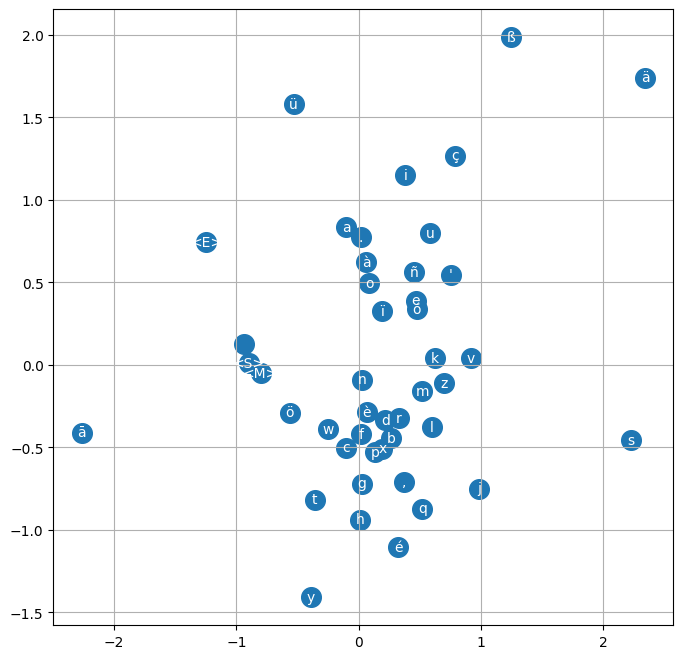

In [277]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")

plt.grid("minor")

### Clearly noticeable that some of the werd characters are outliers. We can remove haikus with these characters and maybe find an improvement?

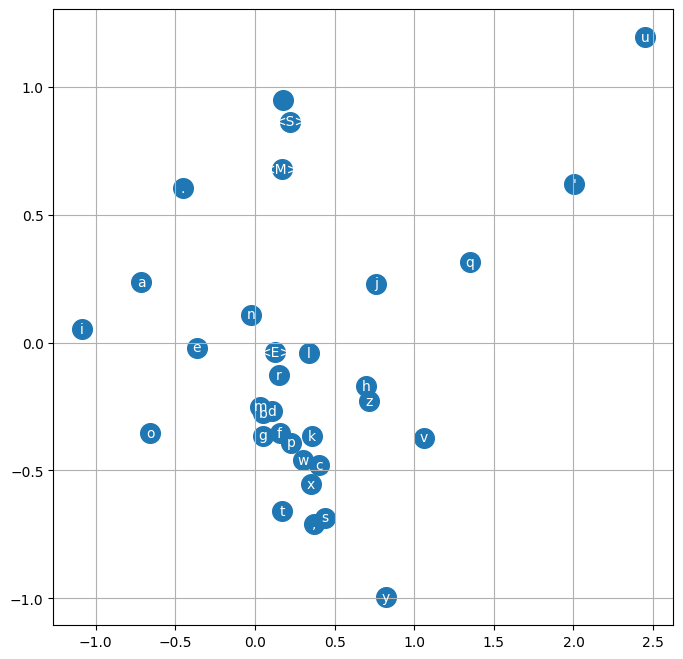

In [325]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")

plt.grid("minor")

In [409]:
print(stoi)

{' ': 0, "'": 1, ',': 2, '.': 3, 'a': 4, 'b': 5, 'c': 6, 'd': 7, 'e': 8, 'f': 9, 'g': 10, 'h': 11, 'i': 12, 'j': 13, 'k': 14, 'l': 15, 'm': 16, 'n': 17, 'o': 18, 'p': 19, 'q': 20, 'r': 21, 's': 22, 't': 23, 'u': 24, 'v': 25, 'w': 26, 'x': 27, 'y': 28, 'z': 29}


In [411]:
for _ in range(20):
    out = []

    context = [3] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # print(ix)
        context = context[1:] + [ix]

        if ix == 3:
            break
        
        out.append(ix)

    print(''.join(itos[i] for i in out))
    print()

foo 

stnon the clane gavirg be's li gete can sut lefdesthiun purdyouthing dicau's all forg an ther timseote feug'vecaradcomts  yeint tod nwilist  nlaveentek  why wistime upseo kel sper py brdy des alds yop's se hilie 

piy ske  fain toms ti pons ped  i she chere as har condeat whrill gethe witr  datt inen   fot b some 

usdefr ine taine authi mary wal  justarnslowh 

start yaiint seg spnba to limce 

in ind  thounn inde hor therems theresees  inoc d senace aly  yastel  wher with syow 

lopn curs  i mpridinfs fait fhour tnporsy 

s yoursealler  an of in's ino nitt ivus hots sonthikhas offekindarc lasch  sure date cered my 

a hcmiethiringht fele the swr jeol flown bpom you aro howerlams yor'ee singraspcrordidalle whry 

e andsest ee thall  myef the  nots  silesceet fore  the car's solook  firthus my yotdey  belt ound't seat  fisd  syraronee anale for a read's  itn  wasu care  lowhet 

top hewism  hes  rony on tevelesvect yith witlondow ehe ceuch my 

for rriv eut roohin that  anfer  er

### I genuinely don't know how but this is a little bit better than the bigram model ;)